In [1]:
import pandas as pd
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
seed = 42
np.random.seed(seed)

This is an analysis (mini) on State of the Union address, since 1791. Note: this study emphasizes discovering topics or themes, with classification secondary.

In [2]:
path = 'state-of-the-union-corpus-1989-2017'
dirs = os.listdir(path)

In [4]:
df = pd.DataFrame(columns=['year', 'president', 'party', 'text'])

for i in range(len(dirs)):
    components = dirs[i].split('_')
    name = components[0]
    year = components[1].split('.')[0]
    df.loc[i,'year'] = year
    df.loc[i,'president'] = name   
    
    filename = os.path.join(path, dirs[i])
    text_file = open(filename, "r")
    
    lines = text_file.read()
    lines = lines.replace('\n', ' ')
    df.loc[i, 'text'] = lines.lower()
    
df.year = df.year.astype(int) 
df.president = df.president.astype(str)
df.text = df.text.astype(str)
print('Shape: ', df.shape)

Shape:  (228, 4)


There are a few presidents that have the same last name (Roosevelt, Bush, Johnson and Adams), so let's clean that up now.

In [5]:
# need to distinuish between Theodore Roosevelt and Franklin D. Roosevelt
indices = df.query("president =='Roosevelt' & year <= 1909").index
df.loc[indices,'president'] = 'Theodore Roosevelt'

indices = df.query("president == 'Roosevelt'").index
df.loc[indices,'president'] = 'Franklin D. Roosevelt'

indices = df.query("president =='Bush' & year <= 1992").index
df.loc[indices,'president'] = 'George H. W. Bush'

indices = df.query("president == 'Bush'").index
df.loc[indices,'president'] = 'George W. Bush'

indices = df.query("president =='Johnson' & year <= 1869").index
df.loc[indices,'president'] = 'Andrew Johnson'

indices = df.query("president == 'Johnson'").index
df.loc[indices,'president'] = 'Lyndon B. Johnson'

indices = df.query("president =='Adams' & year <= 1801").index
df.loc[indices,'president'] = 'John Adams'

indices = df.query("president == 'Adams'").index
df.loc[indices,'president'] = 'John Quincy Adams'


indices = df.query("president =='Harrison' & year <= 1841").index
df.loc[indices,'president'] = 'William Henry Harrison'

indices = df.query("president == 'Harrison'").index
df.loc[indices,'president'] = 'Benjamin Harrison'

Now let's attach the political party to the president (note some presidents changed parties throughout their political career, I am simply listing the party they belonged to while serving as President).

In [6]:
def pres_to_party(name):
    republican = ['Lincoln', 'Grant', 'Hayes', 'Garfield', 'Arthur', 
                  'Benjamin Harrison', 'McKinley', 'Theodore Roosevelt', 
                  'Taft', 'Harding', 'Coolidge', 'Hoover', 'Eisenhower', 
                  'Nixon', 'Ford', 'Reagan', 'George H. W. Bush', 
                  'George W. Bush', 'Trump']
    if name in republican:
        return 'Republican'
    
    democratic = ['Jackson', 'Buren', 'Polk', 'Pierce', 
                  'Buchanan', 'Cleveland', 'Wilson', 'Franklin D. Roosevelt', 
                  'Truman', 'Kennedy', 'Lyndon B. Johnson', 'Carter', 'Clinton', 'Obama']
    if name in democratic:
        return 'Democratic'
    
    whig = ['William Henry Harrison', 'Taylor', 'Fillmore']
    if name in whig:
        return 'Whig'
    
    national_union = ['Andrew Johnson']
    if name in national_union:
        return 'National Union'
    
    
    unaffiliated = ['Washington', 'Tyler']
    if name in unaffiliated:
        return 'Unaffiliated'
    
    federalist = ['John Adams']
    if name in federalist:
        return 'Federalist'
    
    democratic_republican = ['Jefferson', 'Madison', 'Monroe', 'John Quincy Adams']
    if name in democratic_republican:
        return 'Democratic-Republican'

In [7]:
df.party = df.president.apply(pres_to_party)

df.set_index('year', inplace=True)
df.sort_index(inplace=True)
df.head()

,president,party,text
year,,,
1790,Washington,Unaffiliated,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [8]:
# need to drop George Washington's 1790 address as the file is empty
df = df.iloc[1:,:]
df.head()

,president,party,text
year,,,
1791,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1792,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1793,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1794,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...
1795,Washington,Unaffiliated,fellow-citizens of the senate and house of rep...


In [8]:
df.groupby('party').size()

party
Democratic               88
Democratic-Republican    28
Federalist                4
National Union            4
Republican               89
Unaffiliated             10
Whig                      4
dtype: int64

We are simply going to drop those SOTU addresses delivered by presidents that were not a member of the Democratic or Republican parties.  

Since nearly all SOTU addresses start with an acknowledement, we can remove this boilerplate text as it will not add anything to our topic model.

In [39]:
df_new = df[df.party.isin(['Democratic','Republican'])]

In [64]:
def remove_acknowledgement(text):
    return text[re.match('[^\:]*', test_string).end()+2:]

df_new.text = df_new.text.apply(remove_acknowledgement)

In [69]:
df_new.head()

,president,party,text
year,,,
1829,Jackson,Democratic,it affords me pleasure to tender my friendly ...
1830,Jackson,Democratic,the pleasure i have in congratulating you upo...
1831,Jackson,Democratic,the representation of the people has been ren...
1832,Jackson,Democratic,it gives me pleasure to congratulate you upon...
1833,Jackson,Democratic,on your assembling to perform the high trusts...


In [70]:
import re
from gensim import models, corpora
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [71]:
STOPWORDS = stopwords.words('english')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return lemmatize_sent(' '.join(cleaned_text))

In [72]:
df_new['tokens'] = df_new.text.apply(clean_text)
df_new.head()

,president,party,text,tokens
year,,,,
1829,Jackson,Democratic,it affords me pleasure to tender my friendly ...,"[affords, pleasure, tender, friendly, greeting..."
1830,Jackson,Democratic,the pleasure i have in congratulating you upo...,"[pleasure, congratulate, upon, return, constit..."
1831,Jackson,Democratic,the representation of the people has been ren...,"[representation, people, renew, time, since, c..."
1832,Jackson,Democratic,it gives me pleasure to congratulate you upon...,"[give, pleasure, congratulate, upon, return, s..."
1833,Jackson,Democratic,on your assembling to perform the high trusts...,"[assemble, perform, high, trust, people, unite..."


Let's make a **word cloud**, using the original text (not tokenized).

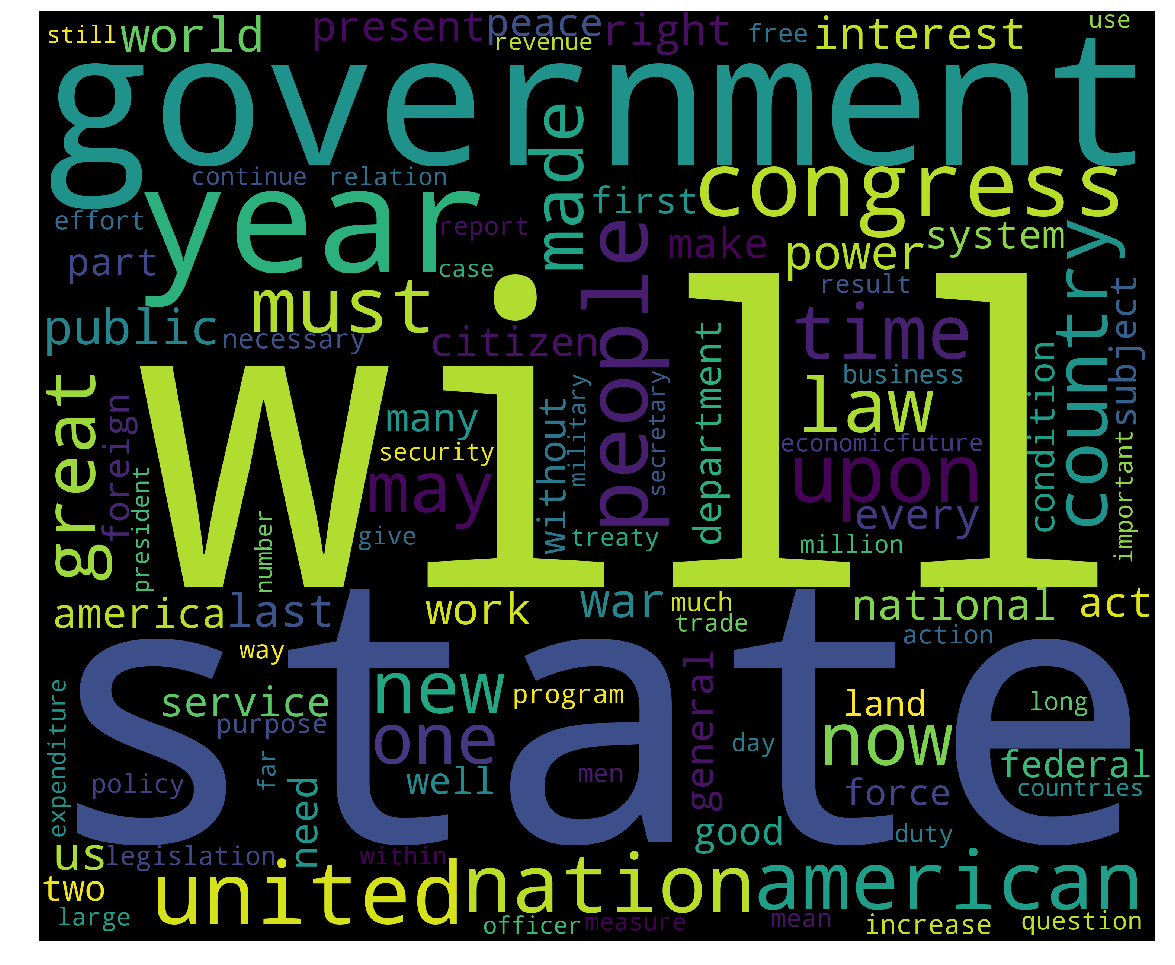

In [74]:
#WordCloud
from wordcloud import WordCloud, STOPWORDS

cleaned_text = ' '.join(list(df_new.text))

wordcloud = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(cleaned_text)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Let's make a **word cloud** using our **tokens** (POS taggged and lemmatized).

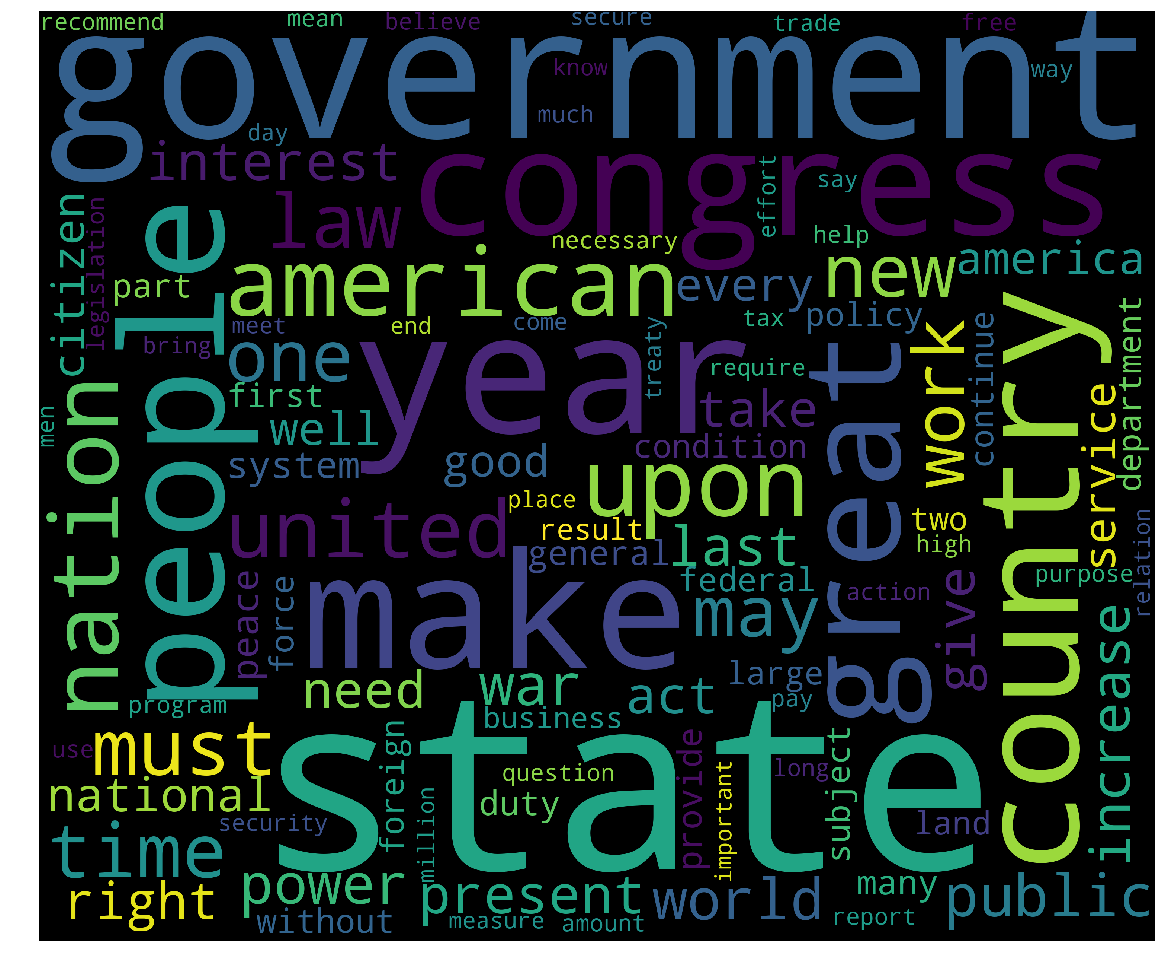

In [75]:
token_string = ''
for tokens in df_new.tokens:
    token_string += ' '.join(tokens) + ' '

wordcloud_tokens = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(token_string)

plt.figure(1,figsize=(20, 20))
plt.imshow(wordcloud_tokens)
plt.axis('off')
plt.show()

# Topic Modeling

In [106]:
NUM_TOPICS = 20

# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(df_new.tokens)

'''
We can "control" the level in which we extract topics from:
  * We can filter out tokens that show up in x% of all SOTU's, in effect
    uncovering more hidden topics (only present in (1-x)% of the SOTUs).
  * A similar strategy can be used to filter out very rare tokens by setting
    no_below

Initially we will not do this, but it follows that this strategy might be helpful

in classification models. In this case we might also want to increase
  the number of latent topics to discover: less frequenct topics could be 
  quite powerful in prediction
'''

'''
    * Adjusting the no_above parameter will in essence extract topics that are unique only to
      certain time periods, eg. vietname, iraq, slavery
''' 
dictionary.filter_extremes(no_above=.3)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in df_new.tokens]

In [107]:
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, 
                            iterations=50, 
                            random_state=seed,
                            num_topics=NUM_TOPICS, 
                            id2word=dictionary)

print("LDA Model: \n\n")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, NUM_TOPICS))
    
print("=" * 40, '\n')

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator))

LDA Model: 


Topic #0: 0.003*"indian" + 0.003*"mexico" + 0.002*"job" + 0.002*"object" + 0.002*"cent" + 0.002*"island" + 0.002*"tariff" + 0.002*"vessel" + 0.002*"tonight" + 0.002*"billion" + 0.002*"soviet" + 0.002*"minister" + 0.002*"convention" + 0.002*"article" + 0.002*"britain" + 0.002*"major" + 0.001*"loan" + 0.001*"conference" + 0.001*"cuba" + 0.001*"coast"
Topic #1: 0.003*"job" + 0.002*"island" + 0.002*"indian" + 0.002*"mexico" + 0.002*"challenge" + 0.002*"tonight" + 0.002*"worker" + 0.002*"billion" + 0.002*"vessel" + 0.002*"object" + 0.002*"note" + 0.002*"cent" + 0.002*"percent" + 0.002*"minister" + 0.002*"loan" + 0.001*"article" + 0.001*"convention" + 0.001*"soviet" + 0.001*"bond" + 0.001*"weapon"
Topic #2: 0.003*"indian" + 0.003*"mexico" + 0.003*"vessel" + 0.002*"convention" + 0.002*"object" + 0.002*"job" + 0.002*"minister" + 0.002*"note" + 0.002*"cent" + 0.002*"island" + 0.002*"gold" + 0.002*"railroad" + 0.002*"spain" + 0.002*"tariff" + 0.002*"export" + 0.002*"tonight" + 0.00

Now that we have extracted the top 10 most likely topics, we can apply them to each address separately.

In [108]:
lda_scores = [] #np.array((len(corpus), NUM_TOPICS))

for i in range(len(corpus)):
    y = lda_model[corpus[i]]
    #lda_scores.append([score[1] for score in y])
    lda_scores.append({score[0]:score[1] for score in y})

lda_df = pd.DataFrame(lda_scores)
lda_df.index = df_new.index
lda_df.fillna(0.0, inplace=True) # not sure about this...

lda_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
year,,,,,,,,,,,,,,,,,,,,
1829,0.100879,0.000000,0.000000,0.0,0.0,0.497401,0.00000,0.0,0.0,0.064508,0.0,0.0,0.0,0.0,0.209933,0.093543,0.000000,0.0,0.0,0.0
1830,0.054197,0.000000,0.010328,0.0,0.0,0.267069,0.07585,0.0,0.0,0.034030,0.0,0.0,0.0,0.0,0.462392,0.028429,0.051949,0.0,0.0,0.0
1831,0.016717,0.000000,0.013533,0.0,0.0,0.104125,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.850513,0.000000,0.000000,0.0,0.0,0.0
1832,0.030347,0.000000,0.000000,0.0,0.0,0.356507,0.00000,0.0,0.0,0.020473,0.0,0.0,0.0,0.0,0.572051,0.000000,0.012350,0.0,0.0,0.0
1833,0.000000,0.028834,0.000000,0.0,0.0,0.173149,0.00000,0.0,0.0,0.035025,0.0,0.0,0.0,0.0,0.646756,0.000000,0.093796,0.0,0.0,0.0


Attach political party to lsi_scores to see if there is any major differences between the political parties.

In [109]:
lda_df['party'] = df_new.party
lda_df.groupby('party').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
party,,,,,,,,,,,,,,,,,,,,
Democratic,0.008109,0.008535,0.002069,0.009261,0.013641,0.139801,0.002739,0.00000,0.011412,0.067812,0.005729,0.002201,0.000848,0.299510,0.125458,0.023860,0.033258,0.071288,0.053504,0.113225
Republican,0.013554,0.010451,0.002986,0.001234,0.001481,0.242049,0.003542,0.00402,0.014850,0.044977,0.000528,0.003145,0.029522,0.266432,0.089042,0.012894,0.005875,0.055906,0.095505,0.093234


## Topic Visualization

In [110]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis


vis_data_lda = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data_lda)

In [ ]:
# save the results to html file
sotu_lda = open('sotu_lda.html', 'w')
pyLDAvis.save_html(vis_data_lda,sotu_lda)

## Hierachical Dirichlet Process 

In [31]:
%%time
# The optional parameter T here indicates that HDP should find no more than 50 topics
# if there exists any.
hdp = models.hdpmodel.HdpModel(corpus, dictionary, T=NUM_TOPICS)
hdp.save('sotu_hdp.model')

CPU times: user 1.92 s, sys: 101 ms, total: 2.02 s
Wall time: 520 ms


In [32]:
vis_data_hdp = gensimvis.prepare(hdp, corpus, dictionary)
pyLDAvis.display(vis_data_hdp)

In [98]:
tokenized_docs = []
for tokens in df_new.tokens:
    ts = ' '.join(tokens)
    tokenized_docs.append(ts)

In [144]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

cv = CountVectorizer(stop_words='english', 
                     max_df=.1, 
                     min_df=5)
bow = cv.fit_transform(tokenized_docs).toarray()

X_train, X_test, y_train, y_test = train_test_split(bow, 
                                                    df_new.party, 
                                                    test_size=0.4, 
                                                    random_state=seed)

'''
hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron', or a regression loss: 'squared_loss',
    'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'
'''
sgd = SGDClassifier(random_state=seed)
sgd.fit(X_train, y_train)
print('Training score: ',sgd.score(X_train, y_train))
y_pred = cross_val_predict(sgd, X_test, y_test) #y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred))

Training score:  1.0
              precision    recall  f1-score   support

  Democratic       0.69      0.77      0.73        35
  Republican       0.75      0.67      0.71        36

   micro avg       0.72      0.72      0.72        71
   macro avg       0.72      0.72      0.72        71
weighted avg       0.72      0.72      0.72        71



In [130]:
tfidf_vec = TfidfVectorizer(stop_words='english', 
                            min_df=9, 
                            max_df=.1)
tfidf = tfidf_vec.fit_transform(tokenized_docs).toarray()

X_train, X_test, y_train, y_test = train_test_split(tfidf, 
                                                    df_new.party, 
                                                    test_size=0.4, 
                                                    random_state=seed)


sgd = SGDClassifier(random_state=seed)
sgd.fit(X_train, y_train)
print('Training score: ',sgd.score(X_train, y_train))
y_pred = cross_val_predict(sgd, X_test, y_test) #y_pred = sgd.predict(X_test)
print(classification_report(y_test, y_pred))

Training score:  1.0
              precision    recall  f1-score   support

  Democratic       0.80      0.69      0.74        35
  Republican       0.73      0.83      0.78        36

   micro avg       0.76      0.76      0.76        71
   macro avg       0.77      0.76      0.76        71
weighted avg       0.77      0.76      0.76        71



In [131]:
X_lda = np.concatenate((bow, lda_df.drop('party', axis=1).values), axis=1)

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X_lda, 
                                                    df_new.party, 
                                                    test_size=0.4, 
                                                    random_state=seed)

sgd_lda = SGDClassifier(random_state=seed, loss='log')
sgd_lda.fit(X_lda_train, y_lda_train)
print('Training score: ',sgd_lda.score(X_lda_train, y_lda_train))
#y_pred_lda = sgd_lda.predict(X_lda_test)
y_pred_lda = cross_val_predict(sgd_lda, X_lda_test, y_lda_test)
print(classification_report(y_lda_test, y_pred_lda))

Training score:  1.0
              precision    recall  f1-score   support

  Democratic       0.63      0.69      0.66        35
  Republican       0.67      0.61      0.64        36

   micro avg       0.65      0.65      0.65        71
   macro avg       0.65      0.65      0.65        71
weighted avg       0.65      0.65      0.65        71



In [143]:
tfidf_vec = TfidfVectorizer(stop_words='english', 
                            min_df=15, 
                            max_df=.2)
tfidf = tfidf_vec.fit_transform(tokenized_docs).toarray()

X_lda = np.concatenate((tfidf, lda_df.drop('party', axis=1).values), axis=1)

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X_lda, 
                                                    df_new.party, 
                                                    test_size=0.4, 
                                                    random_state=seed)

sgd_lda = SGDClassifier(random_state=seed)
sgd_lda.fit(X_lda_train, y_lda_train)
print('Training score: ',sgd_lda.score(X_lda_train, y_lda_train))
#y_pred_lda = sgd_lda.predict(X_lda_test)
y_pred_lda = cross_val_predict(sgd_lda, X_lda_test, y_lda_test)
print(classification_report(y_lda_test, y_pred_lda))

Training score:  1.0
              precision    recall  f1-score   support

  Democratic       0.71      0.63      0.67        35
  Republican       0.68      0.75      0.71        36

   micro avg       0.69      0.69      0.69        71
   macro avg       0.69      0.69      0.69        71
weighted avg       0.69      0.69      0.69        71



| Features     | Micro Avg | Macro Avg | Weighted Avg | 
|--------------|-----------|-----------|--------------| 
| BOW          | 72        | 72        | 72           | 
| TF-IDF       | 76        | 77        | 77           | 
| BOW + LDA    | 65        | 65        | 65           | 
| TF-IDF + LDA | 69        | 69        | 69           | 



## word2vec

# Assess  

We are going to use our LSI and LDA models to assess Trump's latest SOTU address for the topics inferred from previous addresses.

In [ ]:
## Good to use to analyze Trump's latest speech
# 1 - Read the data

# 2 - Clean the data

# 3- Bag of Words

# 4 - Get topics

lda_model.get_document_topics()